In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
from nltk import word_tokenize
from gensim.models import word2vec
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from PIL import Image
from nltk.corpus import stopwords
from unidecode import unidecode
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')
nltk.download('wordnet')

alfabeto = string.ascii_lowercase

stopwords_br = stopwords.words('portuguese')
stopwords_br_dec = [unidecode(x) for x in stopwords_br]
stopwords_br_dec.extend(alfabeto)
stopwords_br_dec = set(stopwords_br_dec)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 28.4 MB/s 


In [ ]:
#carregamento e análise do arquivo de treino
df = pd.read_csv('/content/Train3Classes.csv')
df.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1049721159292346368,Rio elege maior bancada policial de sua histór...,Tue Oct 09 18:00:01 +0000 2018,2,folha
1,1046251157025423360,fiquei tão triste quando eu vi o preço da câme...,Sun Sep 30 04:11:28 +0000 2018,0,:(
2,1041744620206653440,"Para Theresa May, seu plano para o Brexit é a ...",Mon Sep 17 17:44:06 +0000 2018,2,exame
3,1046937084727107589,caralho eu quero proteger a danielly em um pot...,Tue Oct 02 01:37:06 +0000 2018,0,:(
4,1047326854229778432,@SiCaetano_ viva o caos :),Wed Oct 03 03:25:55 +0000 2018,1,:)


In [ ]:
df = df.sample(frac=.5)
print(len(df))

47500


In [ ]:
#função de preprocessamento
def preprocessing_stemmer(string, stopwords=stopwords_br_dec):

    words = word_tokenize(string)

    filtered_words = [w for w in words if w not in stopwords ]

    return filtered_words


In [ ]:
# Removendo os links dos tweets
df['tt_sem_link'] = df.tweet_text.str.split('https://t.co/').str[0]

# Removendo caracteres especiais nas letras
df.tt_sem_link = df.tt_sem_link.apply(unidecode)
# Remove Special Characters and Numbers
df.tt_sem_link = df.tt_sem_link.str.replace('[^a-zA-Z]+', ' ', regex=True)
# Lowercase words
df.tt_sem_link = df.tt_sem_link.str.lower()

df["filtered_words"] = df['tt_sem_link'].apply(lambda x: preprocessing_stemmer(x))
df['join_words'] = df['filtered_words'].apply(lambda x: ' '.join(x))
df.head()

,id,tweet_text,tweet_date,sentiment,query_used,tt_sem_link,filtered_words,join_words
0,1049721159292346368,Rio elege maior bancada policial de sua histór...,Tue Oct 09 18:00:01 +0000 2018,2,folha,Rio elege maior bancada policial de sua historia,"[rio, elege, maior, bancada, policial, historia]",rio elege maior bancada policial historia
1,1046251157025423360,fiquei tão triste quando eu vi o preço da câme...,Sun Sep 30 04:11:28 +0000 2018,0,:(,fiquei tao triste quando eu vi o preco da came...,"[fiquei, tao, triste, vi, preco, camera]",fiquei tao triste vi preco camera
2,1041744620206653440,"Para Theresa May, seu plano para o Brexit é a ...",Mon Sep 17 17:44:06 +0000 2018,2,exame,"Para Theresa May, seu plano para o Brexit e a ...","[theresa, may, plano, brexit, unica, opcao]",theresa may plano brexit unica opcao
3,1046937084727107589,caralho eu quero proteger a danielly em um pot...,Tue Oct 02 01:37:06 +0000 2018,0,:(,caralho eu quero proteger a danielly em um pot...,"[caralho, quero, proteger, danielly, pote, tad...",caralho quero proteger danielly pote tadinhaa
4,1047326854229778432,@SiCaetano_ viva o caos :),Wed Oct 03 03:25:55 +0000 2018,1,:),@SiCaetano_ viva o caos :),"[sicaetano, viva, caos]",sicaetano viva caos


In [ ]:
#definição das variáveis de treino e teste
target = df['sentiment']
y = label_binarize(target, classes=[0, 1, 2])

X= df['join_words']
data = df['join_words'].map(word_tokenize).values

In [ ]:
total_vocabulary = set(word for tweet in data for word in tweet)

In [ ]:
len(total_vocabulary)
print('Há {} tokens únicos no dataset.'.format(len(total_vocabulary)))

Há 89616 tokens únicos no dataset.


In [ ]:
'''GloVe is an unsupervised learning algorithm for obtaining vector representations 
for words. Training is performed on aggregated global word-word co-occurrence 
statistics from a corpus, and the resulting representations showcase interesting 
linear substructures of the word vector space.'''
glove = {}
with open('/content/glove.twitter.27B.25d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [ ]:
glove['bolsonaro']

array([ 0.20466,  0.96524,  0.35861,  0.37478, -0.26424, -1.5632 ,
       -1.8513 , -0.92202,  0.96155, -1.4074 , -0.28408, -0.69435,
       -0.30128, -0.82033,  0.54735, -0.6938 , -1.4471 , -0.06802,
        1.1639 ,  0.18822,  1.2901 ,  1.2338 , -0.77553, -0.86148,
        0.45594], dtype=float32)

In [ ]:
class W2vVectorizer(object):

    def __init__(self, w2v):
        # TRecebe um dicionario de palavras e vetores como input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])

    # metodo interno que permite a utilização com pipeline
    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
# pipelines para modelos
xgb = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('xgboost', XGBClassifier())])
rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression(max_iter=500))])

In [ ]:
models = [('Logistic Regression', lr),
          ('xgboost', xgb)]

In [ ]:
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

In [ ]:
scores

[('Logistic Regression', 0.6763368421052631), ('xgboost', 0.686378947368421)]

In [ ]:
#gerando métricas dos modelos
metrics = ('recall_weighted','precision_weighted','f1_weighted','accuracy','roc_auc_ovr')
multiple_scores = [(name, cross_validate(model, data, target, cv=2, scoring=metrics)) for name, model, in models]

In [ ]:
#xgb mostrou ser o melhor modelo considerando roc_auc, pode ser melhorado utilizando grid search ou metodos bayesianos na busca dos melhores paramentros
multiple_scores

[('Logistic Regression',
  {'fit_time': array([3.18418717, 3.57894969]),
   'score_time': array([2.49203801, 2.41202307]),
   'test_accuracy': array([0.67966316, 0.67587368]),
   'test_f1_weighted': array([0.67695139, 0.67311107]),
   'test_precision_weighted': array([0.67521923, 0.67123363]),
   'test_recall_weighted': array([0.67966316, 0.67587368]),
   'test_roc_auc_ovr': array([0.84893613, 0.84649558])}),
 ('xgboost',
  {'fit_time': array([31.73684311, 26.31189561]),
   'score_time': array([3.44208336, 3.40521598]),
   'test_accuracy': array([0.69082105, 0.6856    ]),
   'test_f1_weighted': array([0.68752898, 0.68200971]),
   'test_precision_weighted': array([0.68604433, 0.68033114]),
   'test_recall_weighted': array([0.69082105, 0.6856    ]),
   'test_roc_auc_ovr': array([0.86041407, 0.85734763])})]

In [ ]:
xgb

Pipeline(steps=[('Word2Vec Vectorizer',
                 <__main__.W2vVectorizer object at 0x7feaf278a050>),
                ('xgboost', XGBClassifier())])

In [ ]:
#persistindo melhor modelo
dump(xgb, 'xgbtreinado.joblib') 

['xgbtreinado.joblib']

In [ ]:
#leitura dados de teste
df_sub = pd.read_csv('/content/Subm3Classes.csv')
df_sub

,id,tweet_text,tweet_date,query_used
0,1046764676707753987,Apartamento Vila Mariana Praça Monteiro dos Sa...,Mon Oct 01 14:12:01 +0000 2018,:)
1,1047329264943751169,@FalleNCS @BrasilGameShow quero 1x1 de scout. ...,Wed Oct 03 03:35:29 +0000 2018,:)
2,1045443874947313665,mais uma analógica no correio à minha espera :...,Thu Sep 27 22:43:37 +0000 2018,:)
3,1040484298711814144,"Em festa de posse como presidente do STF, Toff...",Fri Sep 14 06:16:02 +0000 2018,folha
4,1045411876887306240,@thethiagor @jubsilva @GSCISA @GrupoMulheRIs A...,Thu Sep 27 20:36:28 +0000 2018,:)
...,...,...,...,...
4995,1049243861732794369,"Não é nada demais , apenas a verdade :) — Oh.....",Mon Oct 08 10:23:25 +0000 2018,:)
4996,1039334757690163201,Veja o que é #FATO ou #FAKE na entrevista de A...,Tue Sep 11 02:08:10 +0000 2018,#fato
4997,1049286902577356801,"@nattvieiira de quem???? queria ver, eu sai po...",Mon Oct 08 13:14:27 +0000 2018,:(
4998,1045349300744671232,ASSASSIN'S CREED ORIGINS: ENFRENTANDO OS IRMÃO...,Thu Sep 27 16:27:49 +0000 2018,:)


In [ ]:
#limpando dados de teste
df_sub['tt_sem_link'] = df_sub.tweet_text.str.split('https://t.co/').str[0]

# Removendo caracteres especiais 
df_sub.tt_sem_link = df_sub.tt_sem_link.apply(unidecode)

df_sub["filtered_words"] = df_sub['tt_sem_link'].apply(lambda x: preprocessing_stemmer(x))
df_sub['join_words'] = df_sub['filtered_words'].apply(lambda x: ' '.join(x))
df_sub.head()

,id,tweet_text,tweet_date,query_used,tt_sem_link,filtered_words,join_words
0,1046764676707753987,Apartamento Vila Mariana Praça Monteiro dos Sa...,Mon Oct 01 14:12:01 +0000 2018,:),Apartamento Vila Mariana Praca Monteiro dos Sa...,"[apartamento, vila, mariana, praca, monteiro, ...",apartamento vila mariana praca monteiro santos...
1,1047329264943751169,@FalleNCS @BrasilGameShow quero 1x1 de scout. ...,Wed Oct 03 03:35:29 +0000 2018,:),@FalleNCS @BrasilGameShow quero 1x1 de scout. ...,"[fallencs, brasilgameshow, quero, scout, dizem...",fallencs brasilgameshow quero scout dizem dou ...
2,1045443874947313665,mais uma analógica no correio à minha espera :...,Thu Sep 27 22:43:37 +0000 2018,:),mais uma analogica no correio a minha espera :...,"[analogica, correio, espera, falta, receber, d...",analogica correio espera falta receber duas le...
3,1040484298711814144,"Em festa de posse como presidente do STF, Toff...",Fri Sep 14 06:16:02 +0000 2018,folha,"Em festa de posse como presidente do STF, Toff...","[festa, posse, presidente, stf, toffoli, canta...",festa posse presidente stf toffoli canta legia...
4,1045411876887306240,@thethiagor @jubsilva @GSCISA @GrupoMulheRIs A...,Thu Sep 27 20:36:28 +0000 2018,:),@thethiagor @jubsilva @GSCISA @GrupoMulheRIs A...,"[thethiagor, jubsilva, gscisa, grupomulheris, ...",thethiagor jubsilva gscisa grupomulheris flavi...


In [ ]:
data_sub = df_sub['join_words'].map(word_tokenize).values

In [ ]:
#fitando modelo escolhido e gerando predições
xgb = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('xgboost', XGBClassifier())])


xgb.fit(data, df['sentiment'])
predictions = xgb.predict(data_sub)



In [ ]:
#Gerando arquivo
file = pd.DataFrame(data={'sentiment_predict':predictions},index = df_sub['id'])
file.to_csv('LuizHenrique&GeorgeSousa_turma735_projeto_2_submission.csv')

In [ ]:
#função para 'printar' wordcloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [ ]:
#criacão do vocabulário
vocabulary = pd.DataFrame(
    np.concatenate(df['filtered_words'].values),
    columns=['word']
)

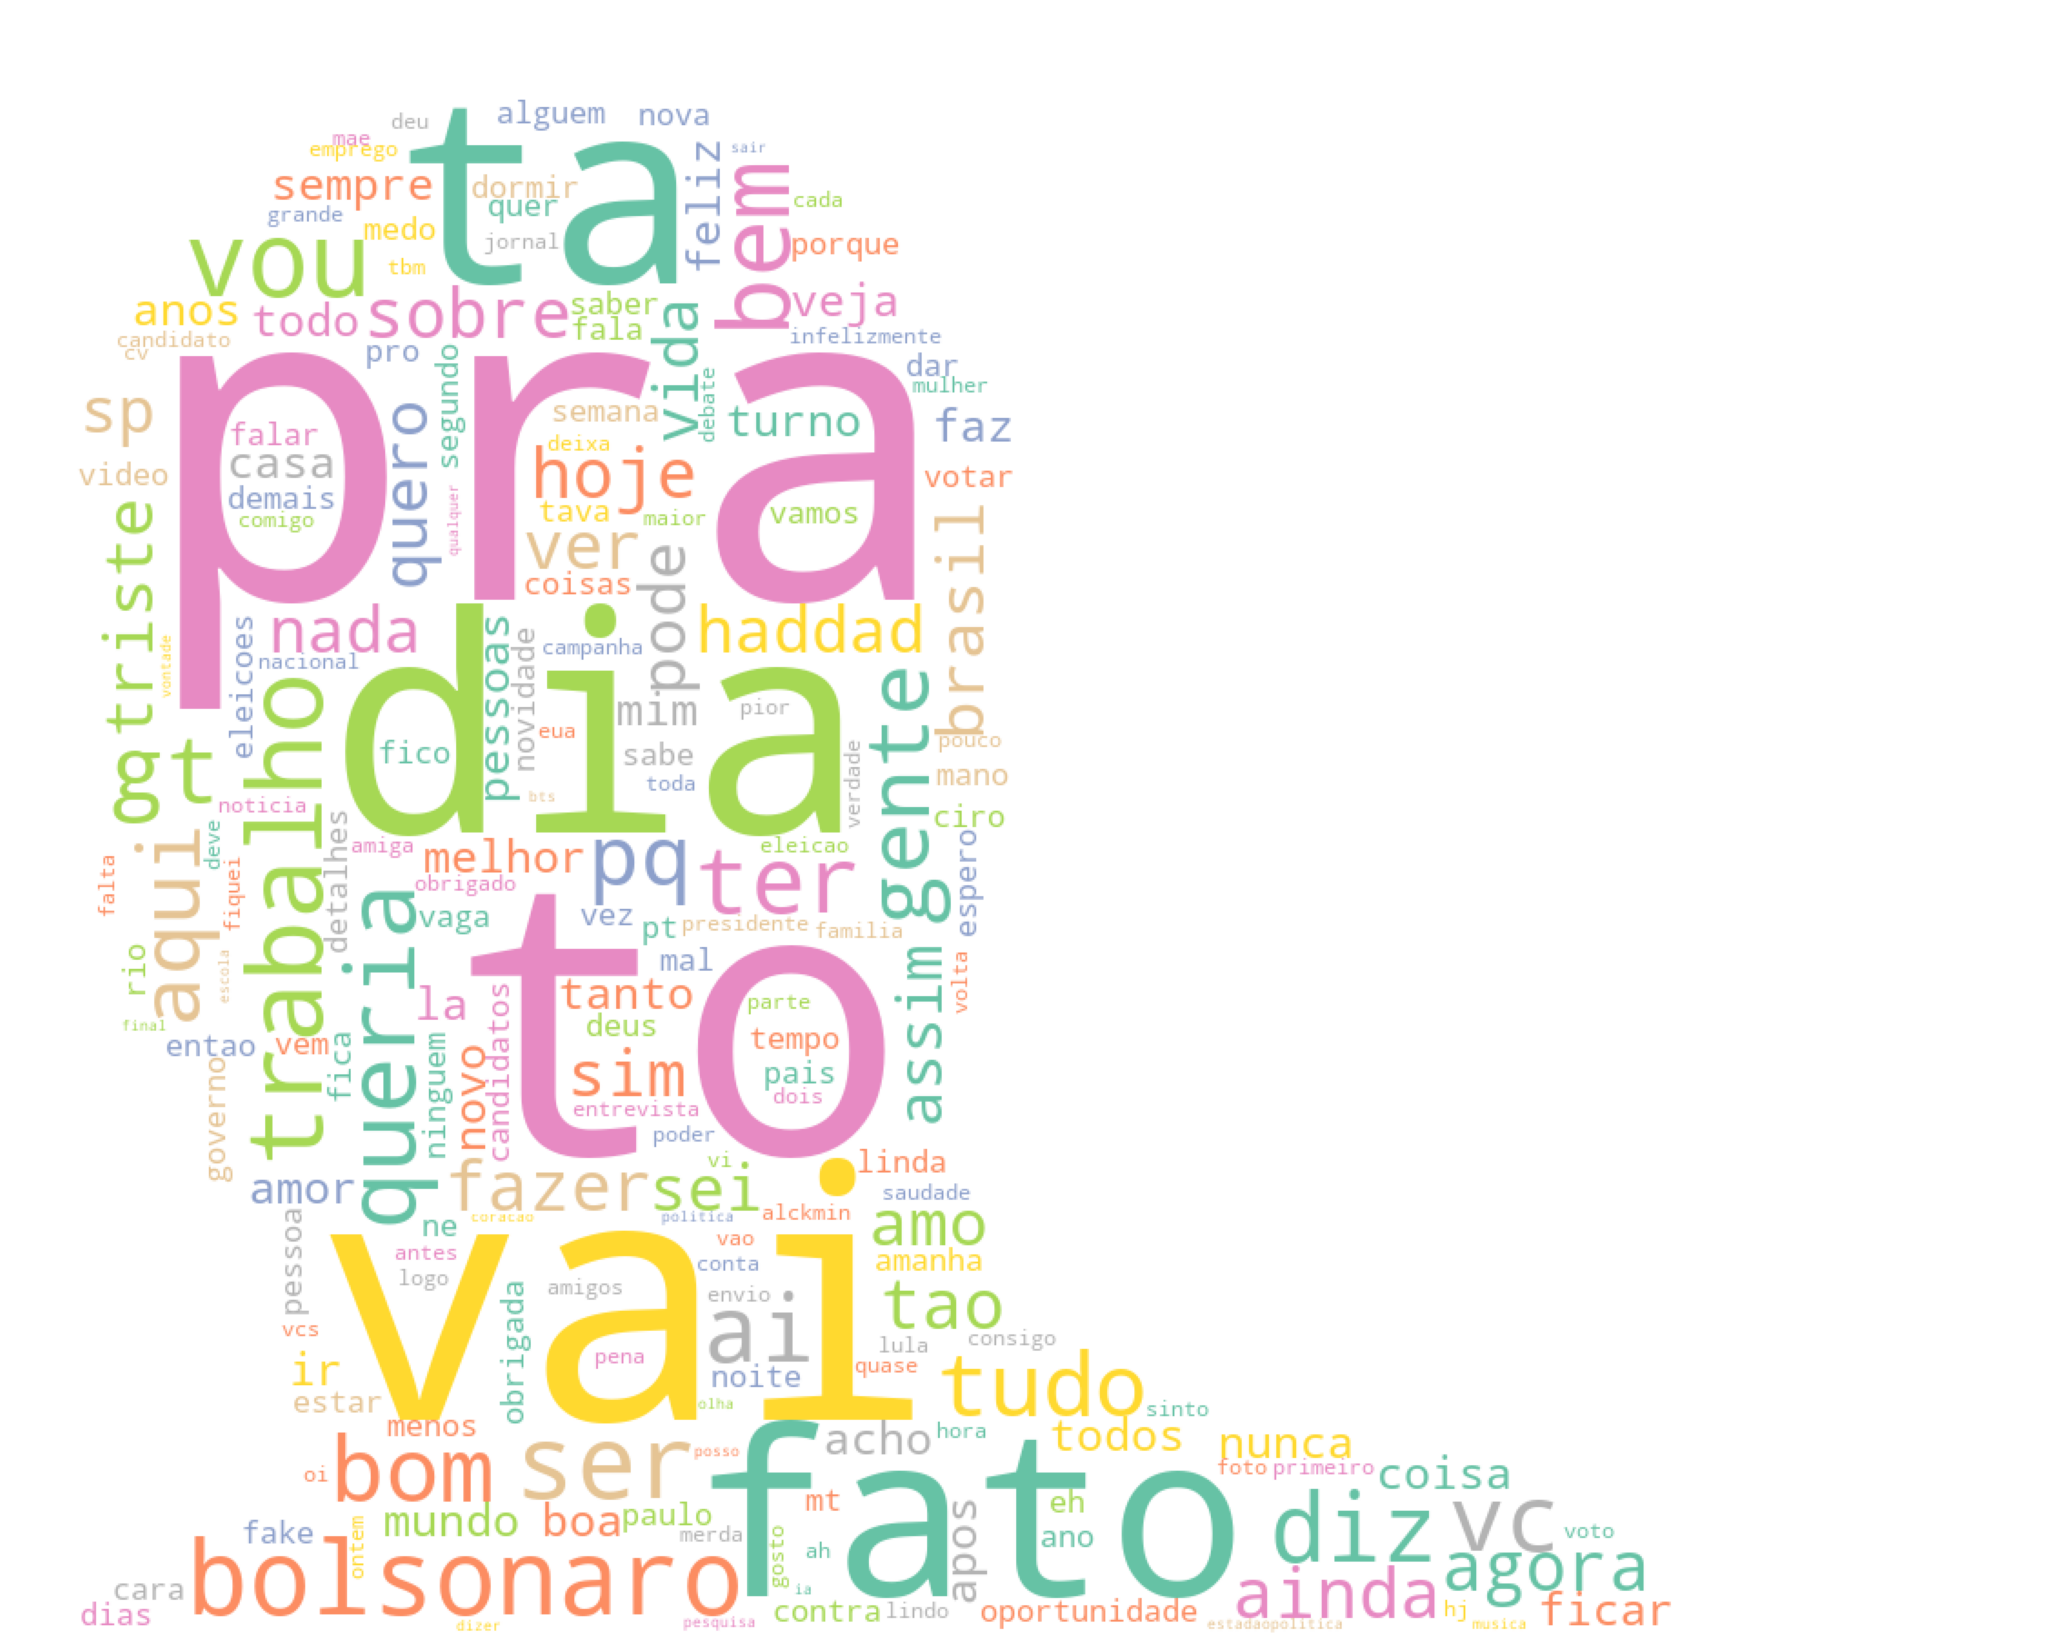

In [42]:
elon_mask = np.array(Image.open('/content/kindpng_1801307.jpg'))
# Generate wordcloud
wordcloud = (WordCloud(width = 3000,
                      height = 2000,
                      random_state=1,
                      background_color='white',
                      colormap='Set2',
                      collocations=False,
                      stopwords = STOPWORDS,
                      mask=elon_mask)
            .generate_from_frequencies(
                vocabulary.groupby('word').size().sort_values(ascending=False).to_dict()
              )
            )
# Plot
plot_cloud(wordcloud)
